In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from classifier import CustomDecisionTreeClassifier
from regressor import CustomDecisionTreeRegressor
from gradient_boosting import MulticlassGB
from utils import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_iris
from sklearn import datasets

# Дерево решений: Классификация

## Данные

In [2]:
iris = load_iris()

df = pd.DataFrame(iris['data'], columns=iris.feature_names)
df['target'] = iris['target']
df['target_names'] = df['target'].replace({i: cls for i, cls in enumerate(iris.target_names)})

X = iris['data']
y = iris['target'].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

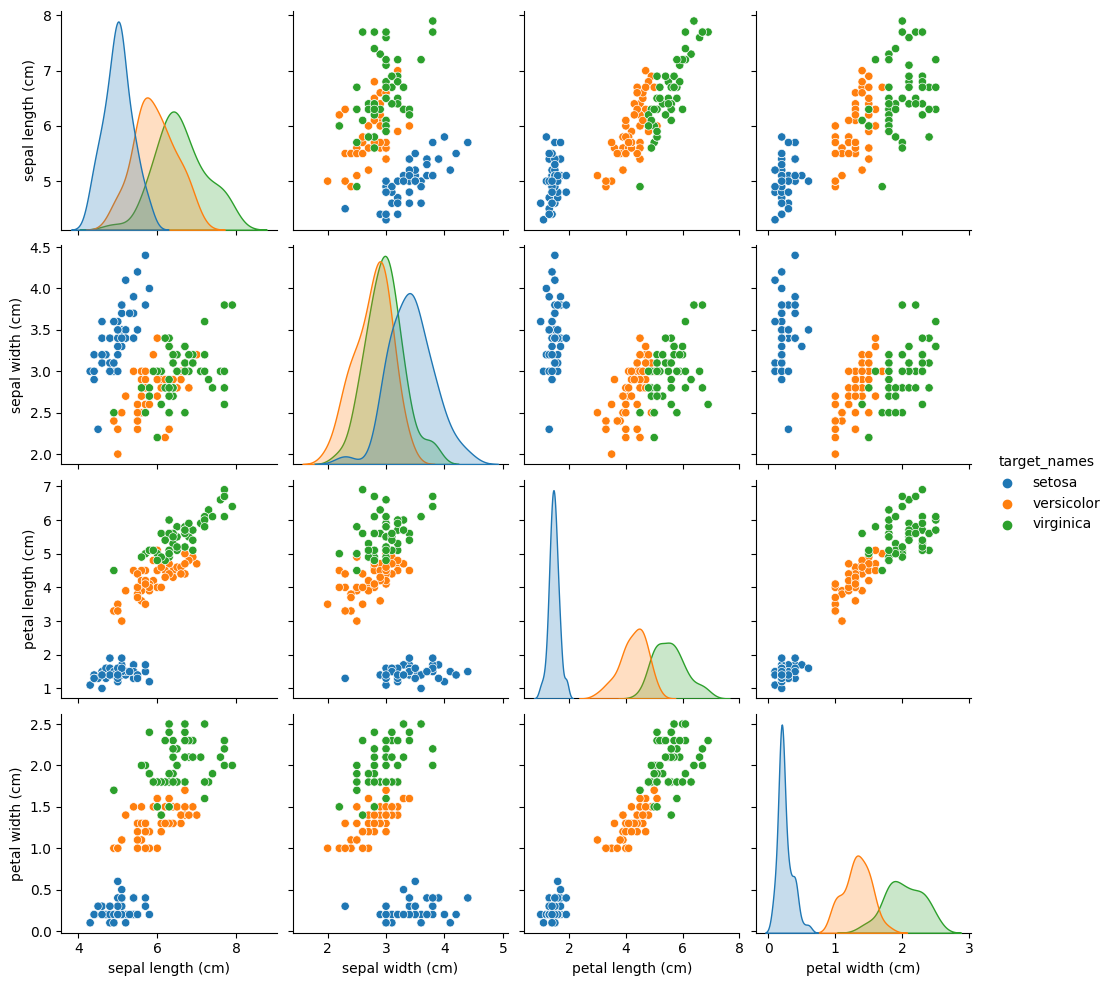

In [3]:
sns.pairplot(df.drop(columns=['target']), hue='target_names')

## Обучение + сравнение с sklearn

In [4]:
model = CustomDecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=4, criterion_name='gini')
model.fit(X_train, y_train)

model_sklearn = DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=4, criterion='gini')
model_sklearn.fit(X_train, y_train)

pass

### Сравнение метрик 

In [5]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



In [6]:
y_pred_sklearn = model_sklearn.predict(X_test)

print(classification_report(y_test, y_pred_sklearn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



### Поэлементное сравнение

In [7]:
accuracy_score(y_pred_sklearn, np.squeeze(y_pred))

1.0

## Визуализация решающий правил

Для визуализации решающих правил дерева возьмем два из четырех исходных признаков, например, petal lenght и sepal length, и обучим классификатор на них

In [8]:
X = df[['sepal width (cm)', 'sepal length (cm)']].values
y = df[['target']].values

In [9]:
# Функция для отрисовки разделяющих областей классов
def draw_contour(ax, model, colors):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    num = 501
    x = np.linspace(*xlim, num)
    y = np.linspace(*ylim, num)
    X = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    Y = model.predict(X)
    con = ax.contourf(
        x, y, np.squeeze(Y).reshape(num, num).T, 
        levels=np.arange(model.n_classes + 1)-0.5, 
        colors=colors, 
        alpha=0.5
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

colors = ['blue', 'orange', 'green']

Визуализация решающих правил в зависимости от максимальной глубины дерева и критерия разбиения

#### gini impurity

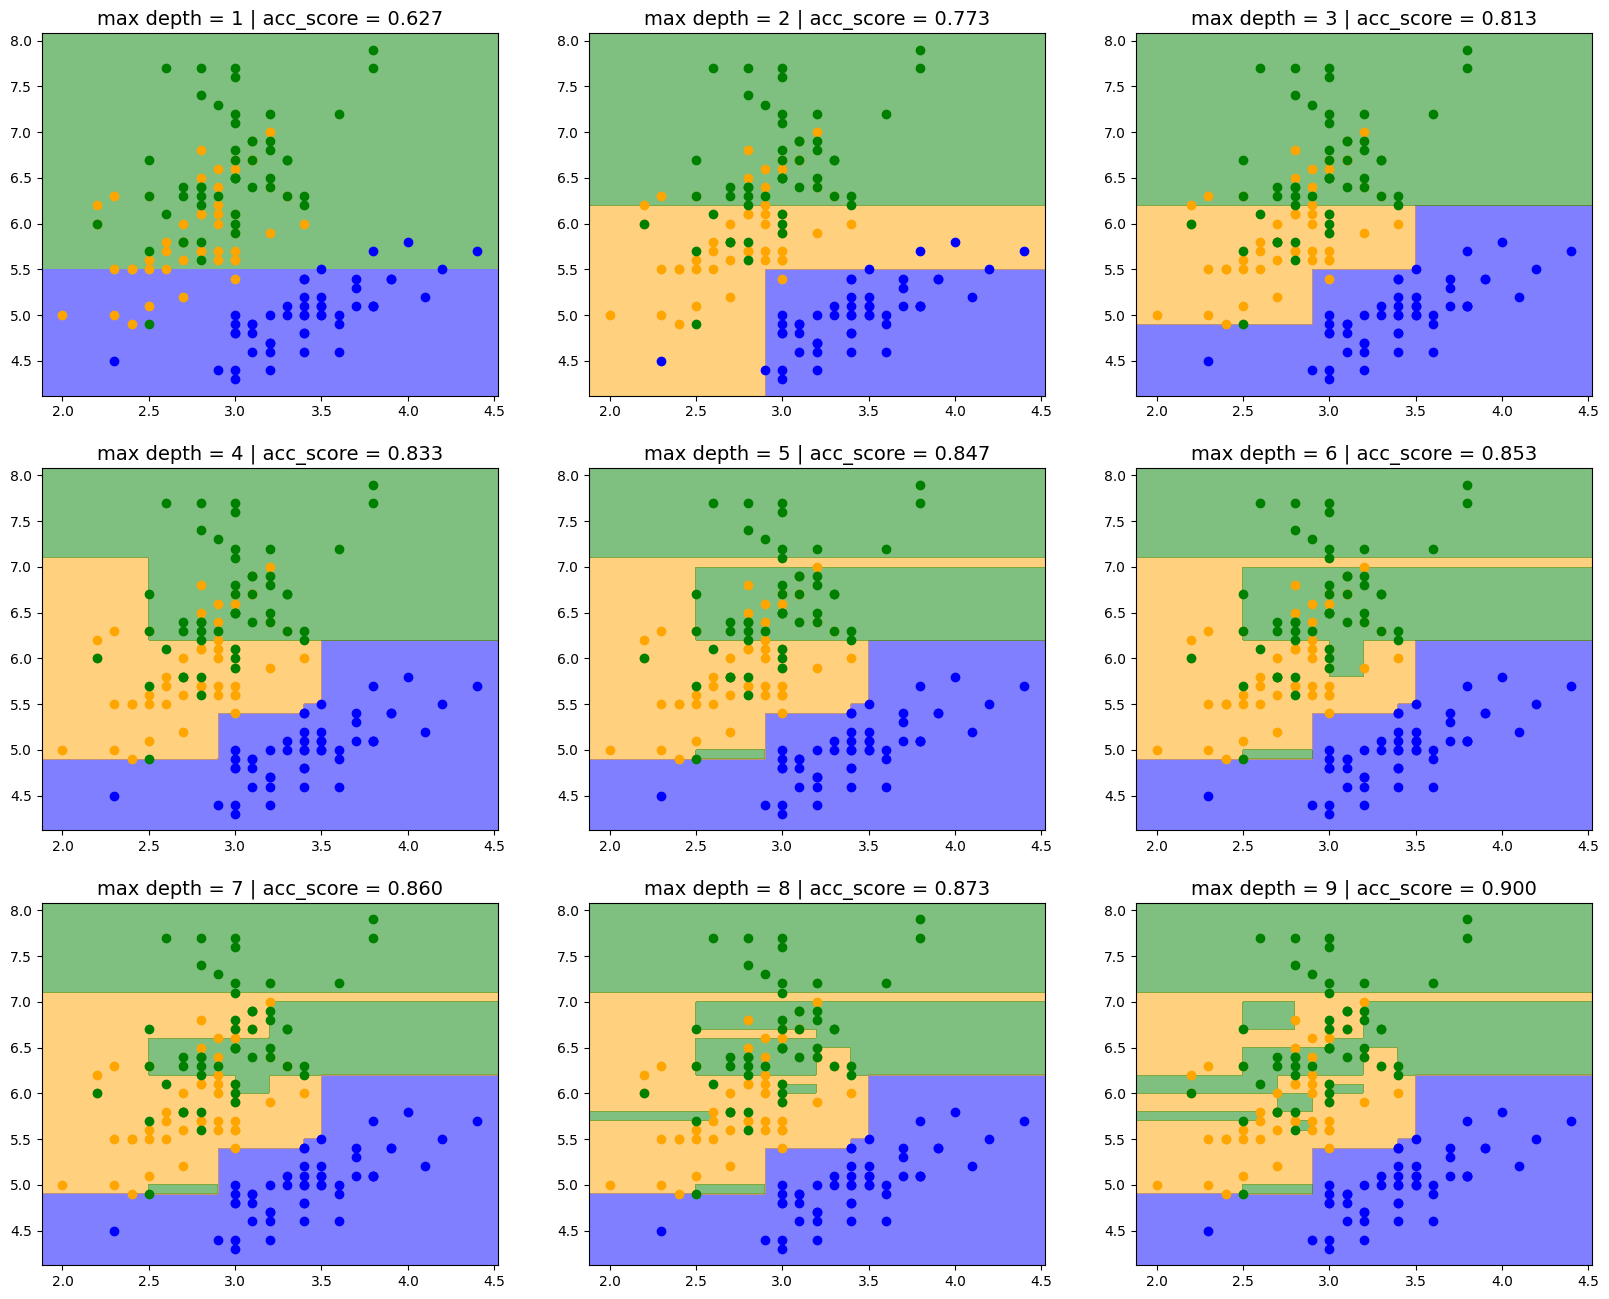

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='gini')
    model.fit(X, y)
    a = accuracy_score(y, model.predict(X))
    
    
    i, j = k // 3, k % 3
    for m in range(model.n_classes):
        ax[i, j].plot(*X[np.squeeze(y) == m].T, 'o', color=colors[m])
        ax[i, j].set_title(f'max depth = {k+1} | acc_score = {a:.3f}', fontsize=14)
        
    draw_contour(ax[i, j], model, colors)    

#### entropy

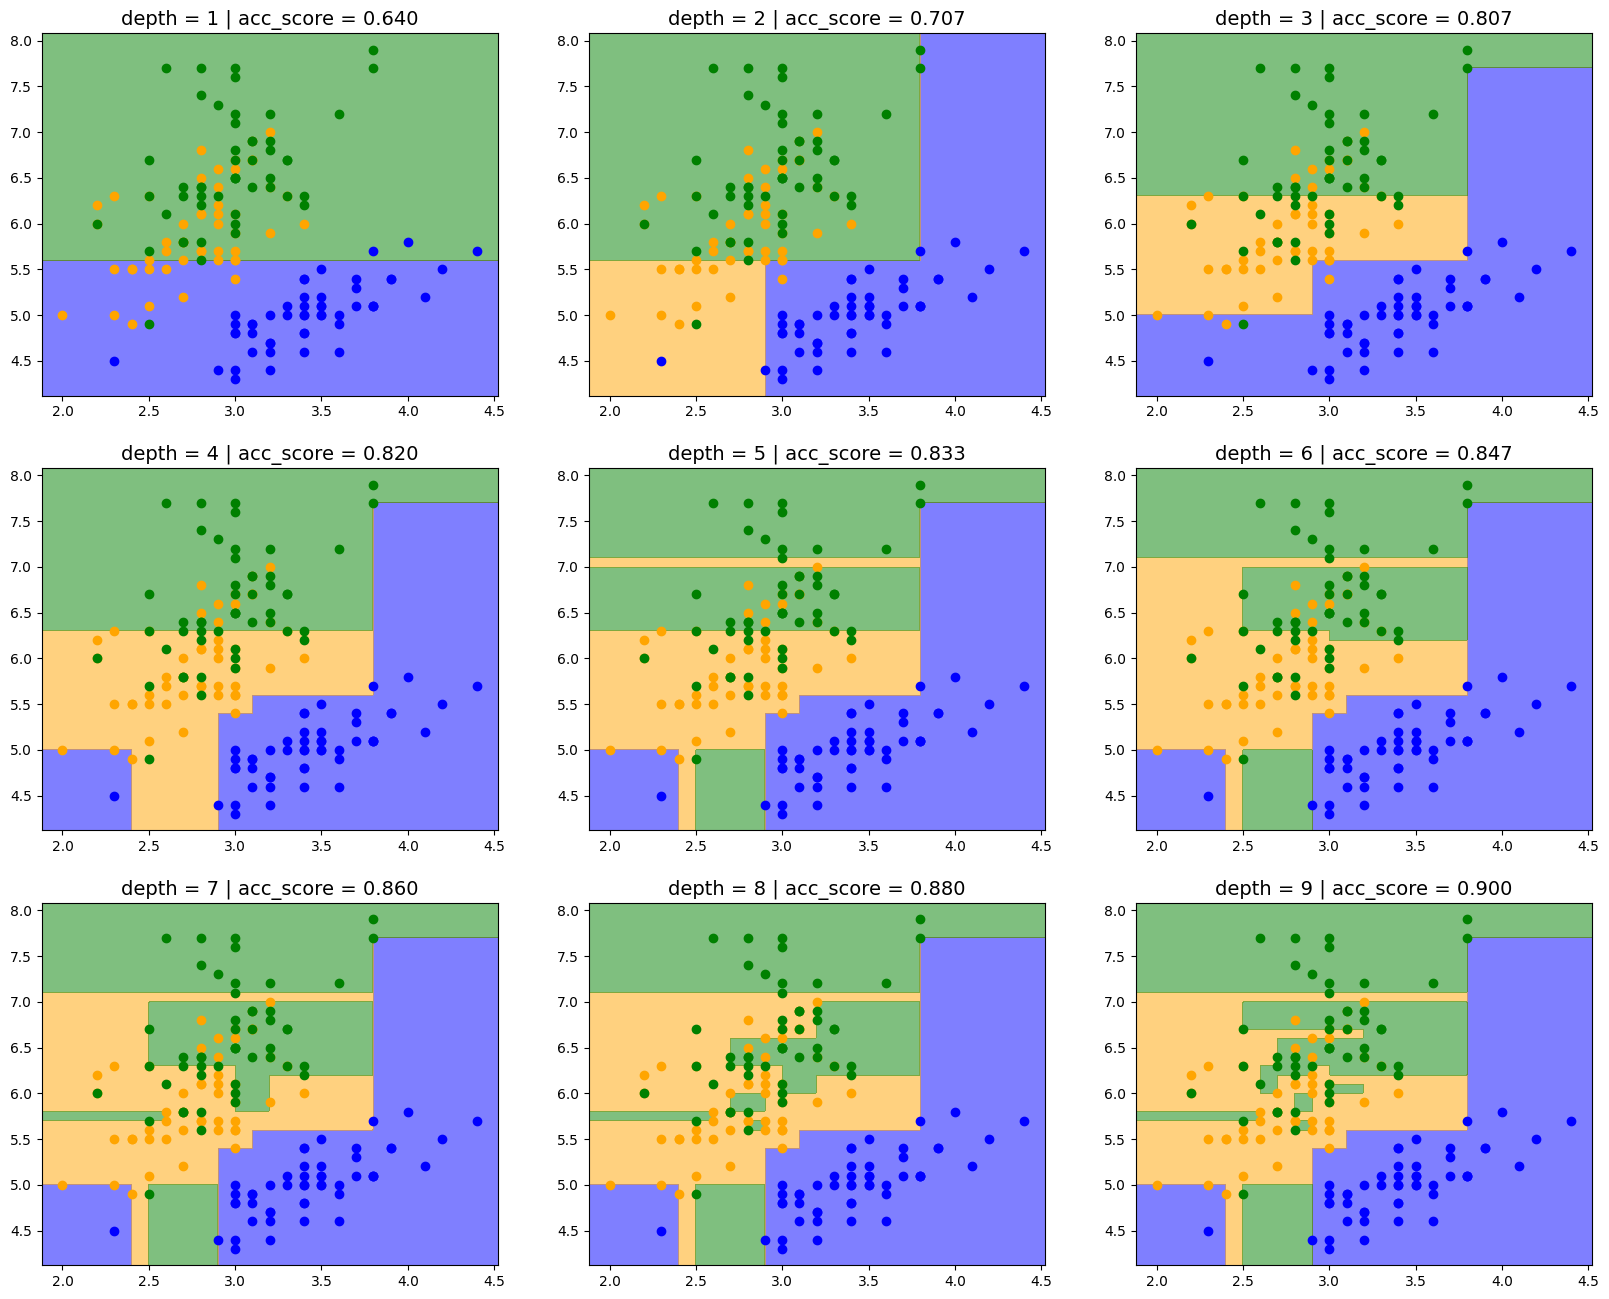

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='entropy')
    model.fit(X, y)
    a = accuracy_score(y, model.predict(X))
    
    
    i, j = k // 3, k % 3
    for m in range(model.n_classes):
        ax[i, j].plot(*X[np.squeeze(y) == m].T, 'o', color=colors[m])
        ax[i, j].set_title(f'depth = {k+1} | acc_score = {a:.3f}', fontsize=14)
        
    draw_contour(ax[i, j], model, colors)    

# Эксперимент с глубиной дерева

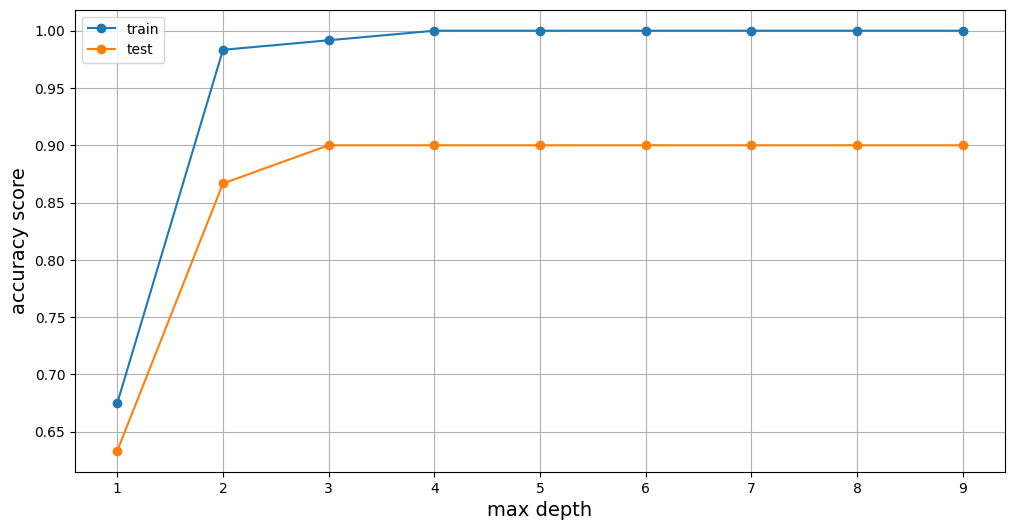

In [12]:
results_train = []
results_test = []

for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='gini')
    model.fit(X_train, y_train)
    
    a = accuracy_score(y_train, model.predict(X_train))
    results_train.append([k+1, a])
    
    a = accuracy_score(y_test, model.predict(X_test))
    results_test.append([k+1, a])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(*np.array(results_train).T, marker='o', label='train')
ax.plot(*np.array(results_test).T, marker='o', label='test')
ax.set_xlabel('max depth', fontsize=14)
ax.set_ylabel('accuracy score', fontsize=14)
ax.legend()
ax.grid()

# Дерево решений: Регрессия

## Данные

In [13]:
df = pd.read_csv('data/day.csv')
df = df.drop(columns=['instant', 'dteday'])
display(df.head())

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


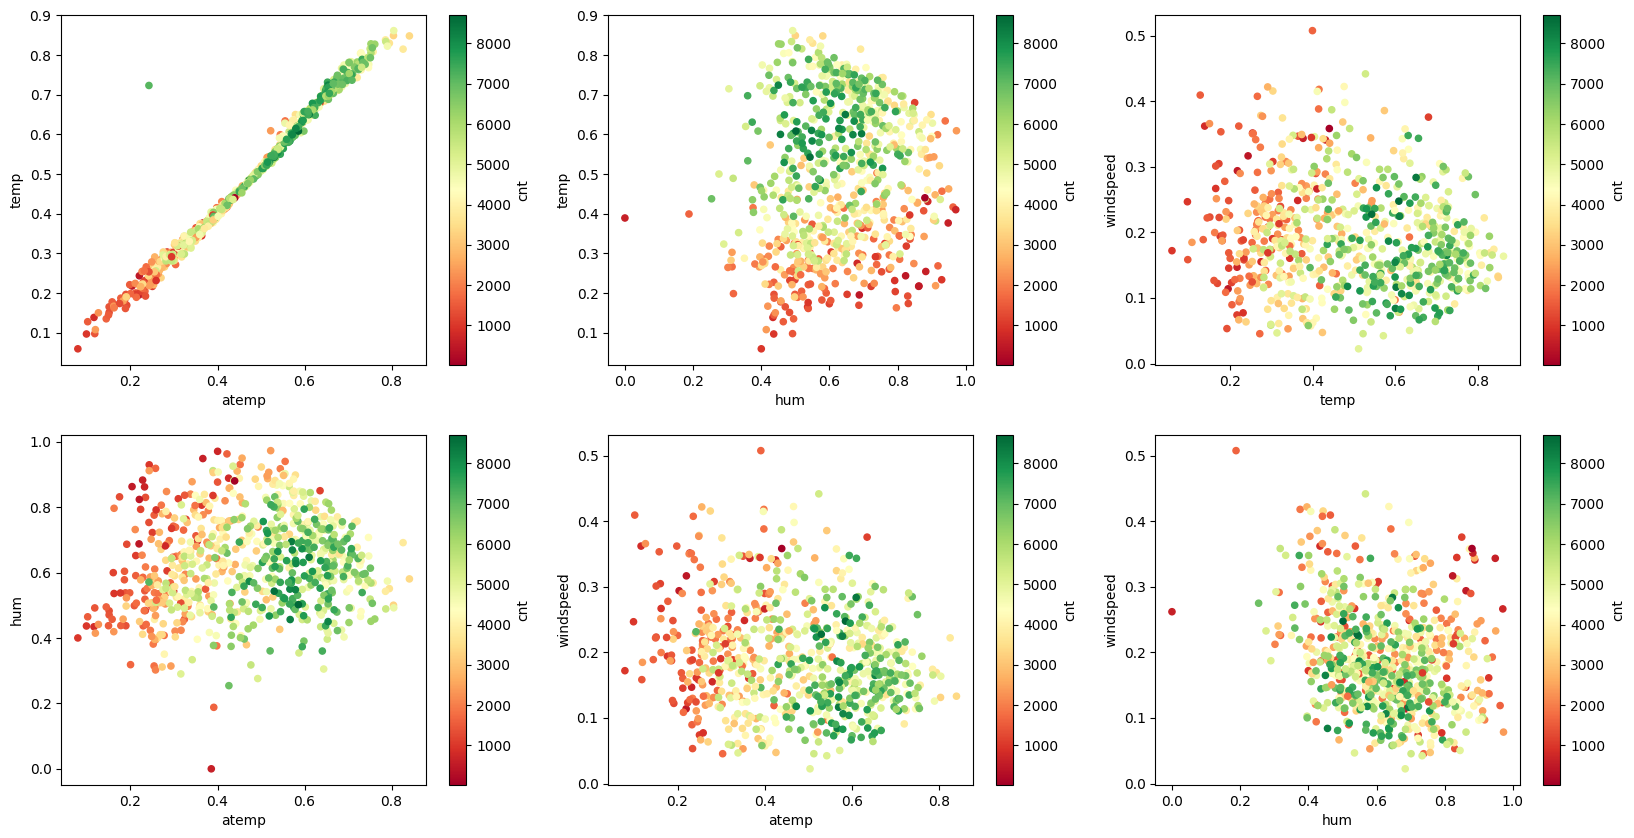

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
feature_pairs = [
    ['atemp', 'temp'],
    ['hum', 'temp'],
    ['temp', 'windspeed'],
    ['atemp', 'hum'],
    ['atemp', 'windspeed'],
    ['hum', 'windspeed']
]
for k, pair in enumerate(feature_pairs):
    i, j = k // 3, k % 3
    df.plot(kind='scatter', x=pair[0], y=pair[1], c='cnt', cmap='RdYlGn', ax=ax[i, j])

In [15]:
features = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 
    'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'
]

X = df[features].values
y = df[['cnt']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Обучение + сравнение с sklearn

In [16]:
model = CustomDecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, criterion_name='variance')
model.fit(X_train, y_train)

model_sklearn = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
model_sklearn.fit(X_train, y_train)

pass

### Сравнение метрик 

In [17]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

369.88286976538615

In [18]:
y_pred_sklearn = model_sklearn.predict(X_test)
mean_squared_error(y_test, y_pred_sklearn)**0.5

364.1061594471585

### Поэлементное сравнение

In [19]:
mean_squared_error(y_pred_sklearn, np.squeeze(y_pred))**0.5

99.30850397734825

## Визуализация решающий правил

Для визуализации решающих правил дерева возьмем какие нибудь два признака, например, temp и hum, и обучим модель на них

In [20]:
X = df[['temp', 'hum']].values
y = df[['cnt']].values

In [21]:
# Функция для отрисовки разделяющих линий
def draw_levels(ax, model):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    num = 501
    x = np.linspace(*xlim, num)
    y = np.linspace(*ylim, num)
    X = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    Y = model.predict(X)
    con = ax.contourf(
        x, y, np.squeeze(Y).reshape(num, num).T, 
        levels=np.linspace(Y.min(), Y.max()), 
        alpha=0.5,
        cmap = 'RdYlGn'
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


Визуализация решающих правил в зависимости от максимальной глубины дерева и критерия разбиения

#### variance

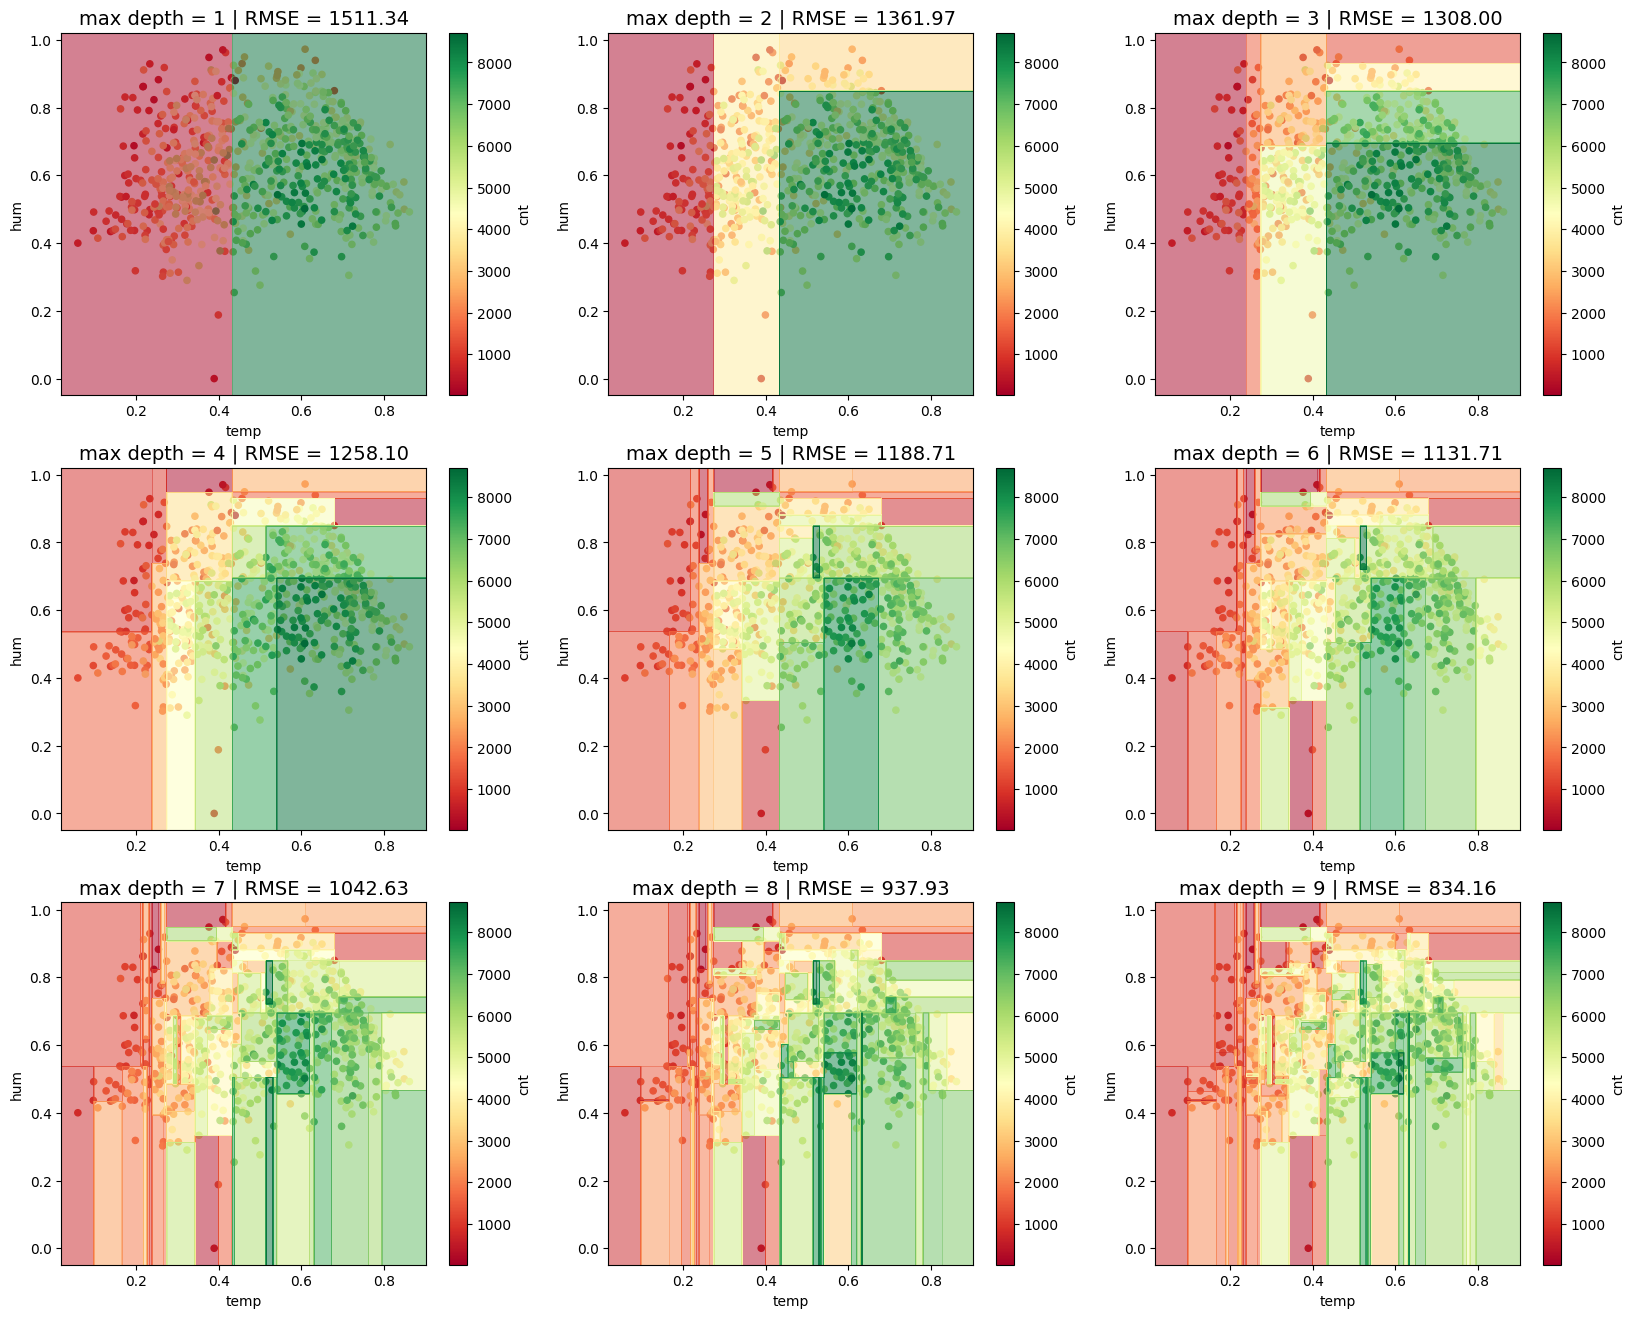

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='variance')
    model.fit(X, y)
    a = mean_squared_error(y, model.predict(X))**0.5
    
    
    i, j = k // 3, k % 3
    ax[i, j].set_title(f'max depth = {k+1} | RMSE = {a:.2f}', fontsize=14)
    df.plot(kind='scatter', x='temp', y='hum', c='cnt', cmap='RdYlGn', ax=ax[i, j])    
    
    draw_levels(ax[i, j], model)    

#### mad_median

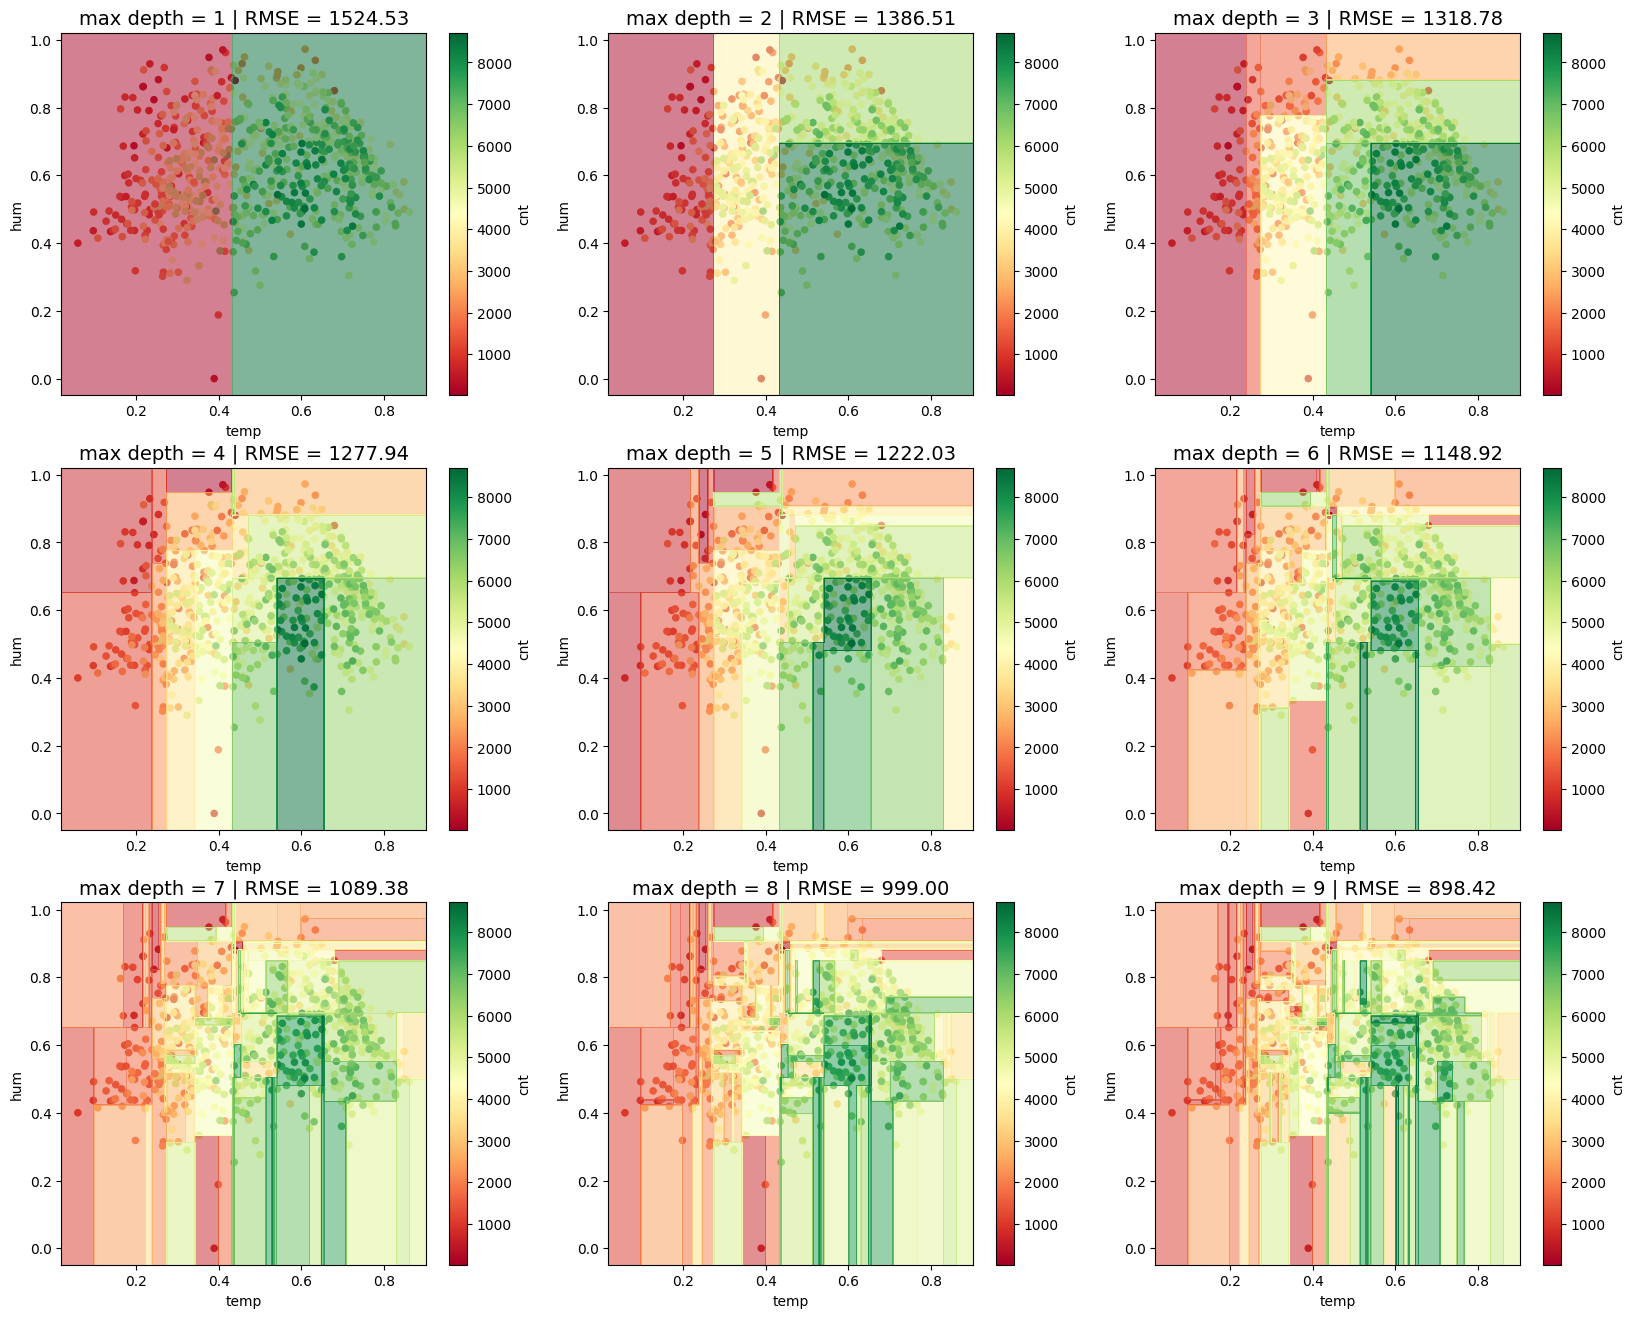

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='mad_median')
    model.fit(X, y)
    a = mean_squared_error(y, model.predict(X))**0.5
    
    
    i, j = k // 3, k % 3
    ax[i, j].set_title(f'max depth = {k+1} | RMSE = {a:.2f}', fontsize=14)
    df.plot(kind='scatter', x='temp', y='hum', c='cnt', cmap='RdYlGn', ax=ax[i, j])    
    
    draw_levels(ax[i, j], model)    

# Эксперимент с глубиной дерева

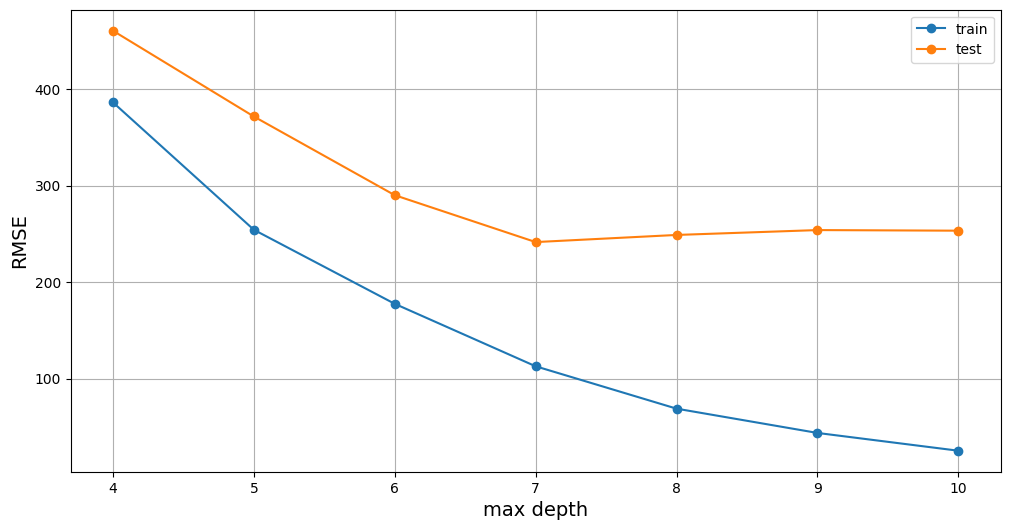

In [24]:
results_train = []
results_test = []

for k in range(3, 10):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='variance')
    model.fit(X_train, y_train)
    
    a = mean_squared_error(y_train, model.predict(X_train))**0.5
    results_train.append([k+1, a])
    
    a = mean_squared_error(y_test, model.predict(X_test))**0.5
    results_test.append([k+1, a])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(*np.array(results_train).T, marker='o', label='train')
ax.plot(*np.array(results_test).T, marker='o', label='test')
ax.set_xlabel('max depth', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend()
ax.grid()

# Градиентный бустинг на деревьях: Классификация

In [25]:
# Параметрами с которыми мы будем обучать деревья
TREE_PARAMS_DICT = {
    'max_depth': 2,
    'learning_rate' : 0.05,
    'n_estimators' : 200
}
N_CLASSES = 3
N_SAMPLES = 2000

Подгрузим данные.

In [26]:
data, target = datasets.make_classification(n_samples=N_SAMPLES, n_classes=N_CLASSES, n_clusters_per_class=1)

In [27]:
gbr = GradientBoostingClassifier(**TREE_PARAMS_DICT)

Качество реализации GBR из sklearn.

In [28]:
np.mean(cross_val_score(gbr, data, target, cv=3, scoring='accuracy'))

0.9369999684842263

Инициализируем нашу версию градиентного бустинга

In [29]:
algo = MulticlassGB(**TREE_PARAMS_DICT)

Качество нашей реализации

In [30]:
np.mean(cross_val_score(algo, data, target, cv=3, scoring='accuracy'))

0.930999215107161

# Готовые реализации Gradient Boosting

LighGBM, CatBoost и XGBoost - три самых популярных реализации градиентного бустинга. У каждого из них есть свои особенности, которые будут описаны ниже. В данном семинаре мы проведем сравнение этих реализаций с точки зрения 

* простоты использования (кол-во действих, необходимых для запуска обучения)

* эффективности (скорость обучения)

* качества (accuracy на тестовой выборке)

Все алгоротмы будут запускаться на дефолтных настройках. Кол-во построенных деревьев (эпох) будет зависить от качества на валидационном сете. Если качество на этом сете не увеличивается в течение 30 эпох, то обучение останавливается, а в качестве итоговой выбирается лучшая эпоха (best_iteration).

In [31]:
def estimate(df, metric):
    '''
    Функция для оценки модели по выборкам
    
    Параметры
    ---------
    df: pd.DataFrame
        Датасет
    metric: callable
        Функция метрики для оценки модели
    '''
    res = df.groupby(SAMPLE).apply(lambda x: metric(x[TARGET], x[PRED]))[[TRAIN, VALID, TEST]]
    res = res.reset_index().set_index(SAMPLE)
    res.columns = [metric.__name__]
    return res.T

## Данные

In [32]:
df = pd.read_csv("./data/horse.csv")
display(df)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,...,55.0,65.0,NaN,NaN,euthanized,no,3205,0,0,no
295,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,44.0,NaN,serosanguious,3.3,euthanized,yes,2208,0,0,yes
296,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,60.0,6.8,NaN,NaN,died,yes,3205,0,0,no
297,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,50.0,6.0,serosanguious,3.4,lived,yes,2208,0,0,yes


In [33]:
SAMPLE = 'sample'
TARGET = 'outcome'
PRED = 'pred'
TRAIN = 'TRAIN'
VALID = 'VALID'
TEST = 'TEST'
RANDOM_STATE = 9

<Axes: xlabel='outcome'>

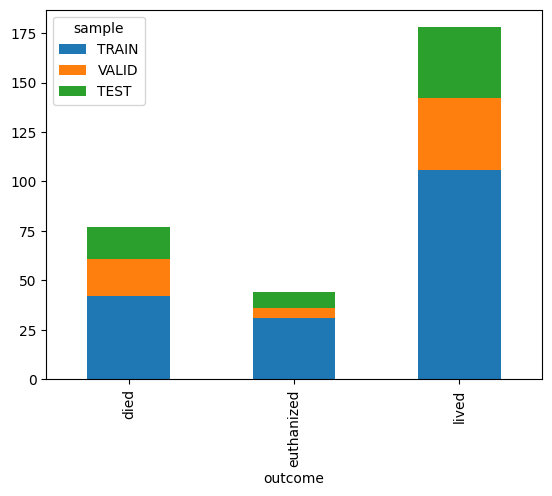

In [34]:
train_val_index, test_index = train_test_split(df.index, test_size=0.2, random_state=RANDOM_STATE)
train_index, valid_index = train_test_split(train_val_index, test_size=0.25, random_state=RANDOM_STATE)

df.loc[train_index, SAMPLE] = TRAIN
df.loc[valid_index, SAMPLE] = VALID
df.loc[test_index, SAMPLE] = TEST

df.groupby([TARGET, SAMPLE])['age'].count().unstack()[[TRAIN, VALID, TEST]].plot(kind='bar', stacked=True)

In [35]:
ID_FEATS = [SAMPLE, TARGET]
CAT_FEATS = [
    'surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 
    'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 
    'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data'
]
NUM_FEATS = [feat for feat in df.columns if feat not in ID_FEATS+CAT_FEATS]

FEATS = sorted(NUM_FEATS + CAT_FEATS)

mask_train = (df[SAMPLE] == TRAIN)
mask_valid = (df[SAMPLE] == VALID)
mask_test = (df[SAMPLE] == TEST)



## LightGBM

In [36]:
! pip install lightgbm

__Преимущества LightGBM:__

1.) Повершинное построение деревьев — ускорение за счёт структуры.

    Мы строим деревья не слой за слоем, а выбираем лист в котором уменьшается наш loss сильнее, чем в остальных. Этот лист дальше разбиваем, растим, и получается, что у нас деревья могут быть несимметричные и глубокие.

2.) GOSS (Gradient-based One-Side Sampling). Используем меньше наблюдений.

    Обращаем бОльшее внимание на наблюдения с бОльшим градиентом.

3.) EFB (Exclusive Feature Bunding). Используем меньше признаков.

    Вместо k-признаков, построить p-связок (p<=k) и использовать только их при нахождении оптимальной точки расщепления при построении деревьев. Причём построим эти связки только один раз — в самом начале.
    
source: https://habr.com/ru/companies/tochka/articles/751012/

In [37]:
import lightgbm as lgb

__Минимальная предобработка данных, которая требуется, чтобы обучение запустилось__


In [38]:
df_lgb = df.copy()

# 1) Обработка категориальных признаков - приведение к типу category
df_lgb[CAT_FEATS] = df_lgb[CAT_FEATS].astype('category')

После приведения к типу category, lightgbm сам понимает, что эти признаки являются категориальными и работает с ними как с категориальныпми признаками

__Обучение__

In [39]:
%%time
clf = lgb.LGBMClassifier(verbosity=-1, random_state=RANDOM_STATE)
clf.fit(
    X=df_lgb.loc[mask_train, FEATS], 
    y=df_lgb.loc[mask_train, TARGET], 
    eval_set=[(df_lgb.loc[mask_valid, FEATS], df_lgb.loc[mask_valid, TARGET])], 
    callbacks=[lgb.early_stopping(30)],
)
df_lgb[PRED] = clf.predict(df_lgb.loc[:, FEATS])

display(estimate(df_lgb, accuracy_score))
print(f'{clf.best_iteration_=}')

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.597989


sample,TRAIN,VALID,TEST
accuracy_score,0.96648,0.716667,0.666667


clf.best_iteration_=37
CPU times: total: 219 ms
Wall time: 191 ms


## Catboost

In [40]:
!pip install catboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


__Преимущества Catboost:__

1.) Симметричные решающие таблицы

    В каждом узле на одном и том же уровне дерева используется одна и та же точка расщепления.

2.) Обработка категориальных признаков

    Реализован модифицированный подход к mean target encoding.

3.) Динамический бустинг

4.) Обучение на GPU
    
source: https://habr.com/ru/companies/tochka/articles/751012/

In [41]:
from catboost import CatBoostClassifier

__Минимальная предобработка данных, которая требуется, чтобы обучение запустилось__


In [42]:
df_catboost = df.copy()

# 1) Обработка категориальных признаков - заполнение пропусков
df_catboost[CAT_FEATS] = df_catboost[CAT_FEATS].fillna('other')

CatBoost в отличие от LightGBM может принимать в себя столбцы с типом object, однако ругается если там присутсвуют NaN. Чтобы CatBoost понял какие из признаков категориальные, достаточно, при вызове fit, передать ему список этих признаков. 

Пропуски в числовых признаках можно не заполнять во всех трех реалиациях

__Обучение__

In [43]:
%%time
clf = CatBoostClassifier(loss_function='MultiClass', verbose=False, od_wait=30, random_state=RANDOM_STATE)
clf.fit(
    df_catboost.loc[mask_train, FEATS], 
    df_catboost.loc[mask_train, TARGET],
    eval_set=(df_catboost.loc[mask_valid, FEATS], df_catboost.loc[mask_valid, TARGET]),
    cat_features=CAT_FEATS
)
df_catboost[PRED] = clf.predict(df_catboost[FEATS]).reshape(-1)

display(estimate(df_catboost, accuracy_score))
print(f'{clf.best_iteration_=}')

sample,TRAIN,VALID,TEST
accuracy_score,0.905028,0.716667,0.75


clf.best_iteration_=216
CPU times: total: 18.8 s
Wall time: 8.91 s


## XGBoost

In [44]:
!pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   Основной ценностью библиотеки XGBoost является эффективная программная реализация. За счет разных оптимизаций, таких как эффективная работа с пропущенными значениями, поиск порога только среди персентилей, оптимизация работа с кэшем и распределенное обучение, достигается выигрыш в десятки или даже сотни раз по сравнению с наивной реализацией.

In [45]:
from xgboost import XGBClassifier

__Минимальная предобработка данных, которая требуется, чтобы обучение запустилось__


In [46]:
df_xgb = df.copy()

# 1) Обработка категориальных признаков - приведение к типу category
df_xgb[CAT_FEATS] = df_xgb[CAT_FEATS].astype('category')

# 2) Кодирование таргета целочисленным типом
df_xgb, _ = feature_encoding(df_xgb, [TARGET])

Аналогичным LightGBM образом происходит предобработка категориальных признаков у XGBoost. Дополнительно, если целевые классы не представлены целочисленным типом, XGBoost попросит их закодировать.

__Обучение__

In [47]:
import xgboost as xgb

In [48]:
%%time
clf = XGBClassifier(enable_categorical=True, early_stopping_rounds=30, verbosity=0, random_state=RANDOM_STATE)
clf.fit(
    X=df_xgb.loc[mask_train, FEATS], 
    y=df_xgb.loc[mask_train, TARGET], 
    eval_set=[(df_xgb.loc[mask_valid, FEATS], df_xgb.loc[mask_valid, TARGET])],
)

df_xgb[PRED] = clf.predict(df_xgb.loc[:, FEATS])

display(estimate(df_xgb, accuracy_score))
print(f'{clf.best_iteration=}')

[0]	validation_0-mlogloss:0.93992
[1]	validation_0-mlogloss:0.85085
[2]	validation_0-mlogloss:0.80382
[3]	validation_0-mlogloss:0.76417
[4]	validation_0-mlogloss:0.73534
[5]	validation_0-mlogloss:0.70091
[6]	validation_0-mlogloss:0.67025
[7]	validation_0-mlogloss:0.65067
[8]	validation_0-mlogloss:0.64706
[9]	validation_0-mlogloss:0.64838
[10]	validation_0-mlogloss:0.64329
[11]	validation_0-mlogloss:0.62977
[12]	validation_0-mlogloss:0.62780
[13]	validation_0-mlogloss:0.62007
[14]	validation_0-mlogloss:0.62403
[15]	validation_0-mlogloss:0.61980
[16]	validation_0-mlogloss:0.61508
[17]	validation_0-mlogloss:0.61594
[18]	validation_0-mlogloss:0.61875
[19]	validation_0-mlogloss:0.62072
[20]	validation_0-mlogloss:0.62116
[21]	validation_0-mlogloss:0.62259
[22]	validation_0-mlogloss:0.63244
[23]	validation_0-mlogloss:0.63454
[24]	validation_0-mlogloss:0.64596
[25]	validation_0-mlogloss:0.65260
[26]	validation_0-mlogloss:0.65659
[27]	validation_0-mlogloss:0.65290
[28]	validation_0-mlogloss:0.6

sample,TRAIN,VALID,TEST
accuracy_score,1.0,0.733333,0.733333


clf.best_iteration=16
CPU times: total: 266 ms
Wall time: 1.03 s


## Заключение

|           | Accuracy | Number of trees |
|-----------|----------|-----------------|
|  LightGBM | 0.66     | 37              |
|  CatBoost | 0.75     | 216             |
|  XGBoost  | 0.73     | 16              |

Лучшую метрику (75 %) показал CatBoost, но пришлось подождать несколько секунд. За это время CatBoost построил аж 216 деревьев. Вторым оказался XGBoost - отличное сочетание качества (73 %) и скорости (меньше секунды). LightGBM работает впечатляюще быстро, даже быстрее чем XGBoost - он построил большее кол-во деревьев, при этом потратил меньшее количество времени. Но качество оставляет желать лучшего (всего 66 %).

Данное сравнение не дает однозначное представление о том какая из реализаций лучше. Представленные результаты являются частным случаем работы алгоритмов и зависит от гиперпараметров, датасета и даже от RANDOM_STATE. Объективное сравнение требует большего количества тестов и более серьезных датасетов.

## Подбор гиперпараметров на LightGBM с помощью optuna

In [81]:
!pip install optuna


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Гиперпараметры — это характеристики модели, которые фиксируются до начала обучения (например - глубина решающего дерева, значение силы регуляризации в линейной модели, learning rate для градиентного спуска). Гиперпараметры, в отличие от параметров задаются разработчиком модели перед ее обучением, в свою очередь параметры модели настраиваются в процессе обучения модели на данных.

Optuna — это фреймворк для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

Ключевые особенности фреймворка:

    1.) Настраиваемое пространство поиска гиперпараметров. Разработчик может самостоятельно задать пространство для поиска гиперпараметров, используя базовый синтаксис Python (циклы, условия).

    2.) Алгоритмы SoTA для выбора гиперпараметров из пространства заданного разработчиком (samplers) и для ранней остановки бесперспективных экспериментов (pruners). В Optuna представлены различные алгоритмы семплирования и прунинга, разработчик может выбрать какой-то конкретный, оставить дефолтный, или написать свой собственный.

    3.) Легкость расспаралеливания процесса поиска гиперпараметров. Также к Optuna можно прикрутить dashboard с визуализацией обучения в реальном времени.

source: https://habr.com/ru/articles/704432/

In [82]:
import optuna
optuna.logging.set_verbosity(0)

In [83]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 50, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 50, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 60, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 25),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
    }

    clf = lgb.LGBMClassifier(
        **param, 
        metric='multi_logloss',
        random_state=RANDOM_STATE,
        verbosity=-1,
        num_iterations=500,
    )
    clf.fit(
        X=df_lgb.loc[mask_train, FEATS], 
        y=df_lgb.loc[mask_train, TARGET], 
        eval_set=[(df_lgb.loc[mask_valid, FEATS], df_lgb.loc[mask_valid, TARGET])], 
        callbacks=[lgb.early_stopping(30, verbose=0)],
    )
    df_lgb[PRED] = clf.predict(df_lgb.loc[:, FEATS])
    a = accuracy_score(df_lgb.loc[mask_valid, TARGET], df_lgb.loc[mask_valid, PRED])

    return a

In [84]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(sampler=sampler, study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=150)

In [85]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  150
Best trial:
  Value:  0.8
  Params: 
    learning_rate: 0.10553284924652936
    reg_alpha: 2.151586742944252
    reg_lambda: 34.69372201680954
    num_leaves: 81
    colsample_bytree: 0.8990880874540567
    subsample: 0.5021708799514719
    subsample_freq: 9
    min_child_samples: 12
    max_depth: 10


In [86]:
clf = lgb.LGBMClassifier(
    **study.best_params, 
    metric='multi_logloss',
    random_state=RANDOM_STATE,
    verbosity=-1,
    num_iterations=500,
)
clf.fit(
    X=df_lgb.loc[mask_train, FEATS], 
    y=df_lgb.loc[mask_train, TARGET], 
    eval_set=[(df_lgb.loc[mask_valid, FEATS], df_lgb.loc[mask_valid, TARGET])], 
    callbacks=[lgb.early_stopping(30, verbose=0)],
)
df_lgb[PRED] = clf.predict(df_lgb.loc[:, FEATS])

display(estimate(df_lgb, accuracy_score))
print(f'{clf.best_iteration_=}')

sample,TRAIN,VALID,TEST
accuracy_score,0.804469,0.8,0.65


clf.best_iteration_=198


__Выводы:__

Подбор гиперпараметров позволил существенно улучшить качество на валидационной выборке, но на тестовой качество 
снизилось. Следовательно, мы "переобучились" под валидацию в смысле подбора гиперпараметров. Надо быть внимательнее и не допускать этого.